In [1]:
from google.colab import drive

# This will prompt you to authorize the access to your Google Drive.
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
tf.random.set_seed(1)

In [3]:
data_dir = "/content/drive/MyDrive/paintings/own_dataset/"

In [4]:
print(os.listdir(data_dir))

['cleaner.py', 'artists.csv', 'images', 'my_model5', 'my_model6', 'my_model7', 'my_model8']


In [5]:
artists = pd.read_csv(data_dir + 'artists.csv')

artists.shape

(50, 8)

In [6]:
artist_names = ['Andy Warhol', 'Claude Monet', 'Edvard Munch', 'Henri Matisse', 'Leonardo da Vinci', 'Michelangelo', 'Pablo Picasso', 'Rembrandt', 'Salvador Dali', 'Vincent van Gogh']


# Create a boolean mask to select rows that match the artist names
mask = artists['name'].isin(artist_names)

# Rearrange the DataFrame so that rows matching the artist names are at the top
artists = pd.concat([artists[mask], artists[~mask]])

# Now, you have rearranged the artists DataFrame, and you can create artists_choosen
artists_choosen = artists[mask].copy()

# Reset the index of artists_choosen if needed
artists_choosen.reset_index(drop=True, inplace=True)

id_mapping = {
    3: 1,
    5: 2,
    8: 3,
    13: 4,
    26: 5,
    28: 6,
    31: 7,
    37: 8,
    45: 9,
    48: 10
}

# Use the map function to replace the 'id' values

artists_choosen = artists_choosen.rename(columns={'Unnamed: 0': 'id'})
artists_choosen['id'] = artists_choosen['id'].map(id_mapping)


print(artists_choosen.shape)


(10, 8)


<ipython-input-6-6db500cc3385>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  artists_choosen = artists[mask].copy()


In [7]:
artists_choosen['class_weight'] = artists_choosen.paintings.sum() / (artists_choosen.shape[0] *artists_choosen.paintings)
artists_choosen = artists_choosen[['name' , 'paintings', 'class_weight']]
artists_choosen

,name,paintings,class_weight
0,Claude Monet,540,1.021481
1,Salvador Dali,500,1.103200
2,Vincent van Gogh,877,0.628962
3,Pablo Picasso,439,1.256492
4,Leonardo da Vinci,513,1.075244
5,Henri Matisse,521,1.058733
6,Rembrandt,519,1.062813
7,Edvard Munch,532,1.036842
8,Andy Warhol,539,1.023377
9,Michelangelo,536,1.029104


In [27]:
artists_choosen['class_weight'][8] = 1.023377
artists_choosen['class_weight'][8] = artists_choosen['class_weight'][8] * 97.5 / 100
artists_choosen['class_weight'][2] = 0.628962
artists_choosen['class_weight'][2] = artists_choosen['class_weight'][2] * 95 / 100

<ipython-input-27-5eadb26c88e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_choosen['class_weight'][8] = 1.023377
<ipython-input-27-5eadb26c88e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_choosen['class_weight'][8] = artists_choosen['class_weight'][8] * 97.5 / 100
<ipython-input-27-5eadb26c88e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_choosen['class_weight'][2] = 0.628962
<ipython-input-27-5

In [29]:
class_weights = artists_choosen['class_weight'].to_dict()
class_weights

{0: 1.0214814814814814,
 1: 1.1032,
 2: 0.5975139,
 3: 1.2564920273348519,
 4: 1.075243664717349,
 5: 1.0587332053742802,
 6: 1.0628131021194605,
 7: 1.0368421052631578,
 8: 0.997792575,
 9: 1.0291044776119402}

In [30]:

images_dir = data_dir + 'images/'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_choosen['name'].str.replace(' ', '_').values
found = 0
not_found = 0
# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
        found +=1
    else:
        print("Did not find -->", os.path.join(images_dir, name))
        not_found +=1
print("\nClass found: " + str(found) + "\nClass not found: " +  str(not_found) )

Found --> /content/drive/MyDrive/paintings/own_dataset/images/Claude_Monet
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Salvador_Dali
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Vincent_van_Gogh
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Pablo_Picasso
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Leonardo_da_Vinci
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Henri_Matisse
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Rembrandt
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Edvard_Munch
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Andy_Warhol
Found --> /content/drive/MyDrive/paintings/own_dataset/images/Michelangelo

Class found: 10
Class not found: 0


In [31]:
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = artists_choosen.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4415 images belonging to 10 classes.
Found 1098 images belonging to 10 classes.
Total number of batches = 137 and 34


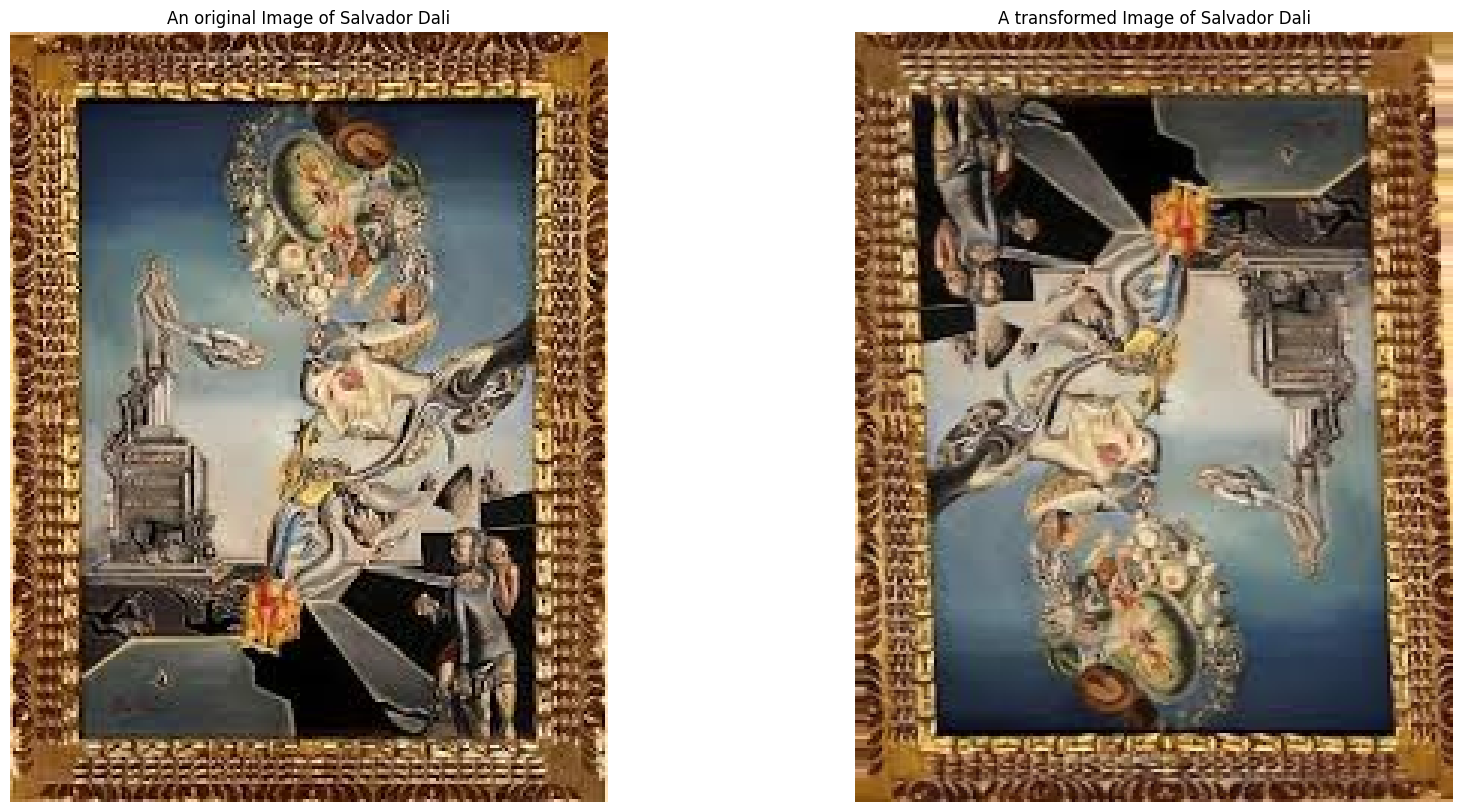

In [32]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [33]:
import tensorflow as tf

class LeakyReLULayer(tf.keras.layers.Layer):
    def __init__(self, alpha=0.01, **kwargs):
        super(LeakyReLULayer, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        return tf.keras.backend.relu(inputs, alpha=self.alpha)


In [57]:
from tensorflow.keras import layers, models
num_classes = 10
# Define the Conv2 model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Flatten the output for the fully connected layers
model.add(layers.Flatten()) # Fully Connected Layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout to prevent overfitting
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout to prevent overfitting
model.add(LeakyReLULayer(alpha=0.01))
model.add(layers.Dense(num_classes, activation=None))

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [61]:
from tensorflow import keras
model = keras.models.load_model(data_dir+'my_model3')

OSError: ignored

In [ ]:
history1 = model.fit(
    x=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)
model.save('my_model')

Epoch 1/10
137/137 [==============================] - 126s 839ms/step - loss: 4.5184 - accuracy: 0.0913 - val_loss: 2.3116 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - 118s 822ms/step - loss: 2.3626 - accuracy: 0.0935 - val_loss: 2.3023 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 3/10
137/137 [==============================] - 118s 804ms/step - loss: 2.3136 - accuracy: 0.0986 - val_loss: 2.3023 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 4/10
 14/137 [==>...........................] - ETA: 48s - loss: 2.2907 - accuracy: 0.1049

Process Keras_worker_ForkPoolWorker-3048:
Process Keras_worker_ForkPoolWorker-3049:
Process Keras_worker_ForkPoolWorker-3053:
Process Keras_worker_ForkPoolWorker-3056:
Process Keras_worker_ForkPoolWorker-3041:
Process Keras_worker_ForkPoolWorker-3044:
Process Keras_worker_ForkPoolWorker-3043:
Process Keras_worker_ForkPoolWorker-3045:
Process Keras_worker_ForkPoolWorker-3054:
Process Keras_worker_ForkPoolWorker-3050:
Process Keras_worker_ForkPoolWorker-3042:
Process Keras_worker_ForkPoolWorker-3055:
Process Keras_worker_ForkPoolWorker-3051:
Process Keras_worker_ForkPoolWorker-3047:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-3052:
Process Keras_worker_ForkPoolWorker-3046:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/

In [47]:
# model.save('my_model')
model.save(data_dir+'my_model9')

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from PIL import Image
import io

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import io
import os
import tensorflow as tf

img_path = '/content/image-10.jpeg'
image = image.load_img(img_path, target_size=(224, 224))
image = tf.image.resize(image, [224, 224])  # Resize to 224x224
image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
image = tf.expand_dims(image, axis=0)  # Add batch dimension

predictions = model.predict(image)

result_list = predictions.squeeze().tolist()
print(result_list)

1/1 [==============================] - 0s 20ms/step
[0.0, 4.531761780528252e-33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [ ]:
artists_choosen['class_weight'] = artists_choosen.paintings.sum() / (artists_choosen.shape[0] *artists_choosen.paintings)
artists_choosen = artists_choosen[['name' , 'paintings', 'class_weight']]

artists_choosen

,name,paintings,class_weight
0,Claude Monet,540,1.021481
1,Salvador Dali,500,1.103200
2,Vincent van Gogh,877,0.628962
3,Pablo Picasso,439,1.256492
4,Leonardo da Vinci,513,1.075244
5,Henri Matisse,521,1.058733
6,Rembrandt,519,1.062813
7,Edvard Munch,532,1.036842
8,Andy Warhol,539,1.023377
9,Michelangelo,536,1.029104
